<a href="https://colab.research.google.com/github/adamlutzz/DS-Unit-2-Applied-Modeling/blob/master/DS_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍔

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [163]:
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make all four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [217]:
# first look
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [0]:
# create function to convert to DT

def to_DT(df):
  # prevent warning
  df = df.copy()

  # convert to date-time
  df['Inspection Date'] = pd.to_datetime(df['Inspection Date'], infer_datetime_format=True)

  return df

In [219]:
# apply to_DO
train = to_DT(train)
test = to_DT(test)

# see train
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [0]:
def wrangle(df):

  # prevent warning
  df = df.copy()

  # Drop some columns
  df = df.drop(columns='State')  # Constant

      # Extract components from date_recorded, then drop the original column
  df['year_recorded'] = df['Inspection Date'].dt.year
  df['month_recorded'] = df['Inspection Date'].dt.month
  df['day_recorded'] = df['Inspection Date'].dt.day
  df = df.drop(columns='Inspection Date')

  return df

In [221]:
# wrangle train and val
train = wrangle(train)
test = wrangle(test)

train.shape, test.shape

((51916, 18), (17306, 18))

In [222]:
# I think some inpections resulted in multiple violations
train['Violations'].value_counts().head()

38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED - Comments: INSTRUCTED TO SELF CONTAIN WASTE WATER BUCKET AT PORTABLE SINK.    3
38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED - Comments: 3-COMPARTMENT SINK FAUCET LEAKING. REPAIR SAME.                    3
45. FOOD HANDLER REQUIREMENTS MET - Comments: NO FOOD HANDLER TRAINING IN ILLINOIS CERTIFICATES AT THIS TIME OF INSPECTION, MUST PROVIDE,                                  3
33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS - Comments: DETAIL CLEAN THE INTERIOR OF THE ICE MACHINE.                              3
45. FOOD HANDLER REQUIREMENTS MET - Comments: FOUND FOODHANDLERS AT PREMISES WITH NO FOODHANDLER CERTIFICATES. MUST PROVIDE.                                               3
Name: Violations, dtype: int64

In [223]:
# move each violation into a separate column
split = train['Violations'].str.split(pat = "|", expand=True)
split.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,"6. HANDS WASHED AND CLEANED, GOOD HYGIENIC PR...",18. NO EVIDENCE OF RODENT OR INSECT OUTER OPE...,29. PREVIOUS MINOR VIOLATION(S) CORRECTED 7-4...,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENS...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENS...,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GO...","35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONST...",36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES O...,38. VENTILATION: ROOMS AND EQUIPMENT VENTED A...,"41. PREMISES MAINTAINED FREE OF LITTER, UNNEC...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,45. FOOD HANDLER REQUIREMENTS MET - Comments:...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES O...,42. APPROPRIATE METHOD OF HANDLING OF FOOD (I...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


I don't really have time to see this through but I would like to engineer a feature counting violations. Also I am sure that some Violations result in an automatic fail.

I actually just looked up the documentation and it looks like there are 45 different possible violations. Violations 1-14 are Critical and 15-29 are serious

In [224]:
from sklearn.model_selection import train_test_split

# 80/20 train test split
train, val = train_test_split(train, test_size=.20, stratify=train['Fail'],
                               random_state=11)
# confirm size
train.shape, val.shape

((41532, 18), (10384, 18))

In [0]:
# create target
target = 'Fail'

# create X_features matrix and y_target vector for train
X_train = train.drop(columns=target)
y_train = train[target]

# create X_features matrix and y_target vector for val
X_val = val.drop(columns=target)
y_val = val[target]

# create X_features matrix and y_target vector for test
X_test = test.drop(columns=target)
y_test = test[target]

In [226]:
# imports for pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

# Make pipeline!
RF = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(random_state=11, n_jobs=-1)
)
# Fit on train, score on val
RF.fit(X_train, y_train)
y_pred = RF.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.7317026194144838


I expected to see leakage here but with a score that low I don't see where there would be leakage

In [227]:
from sklearn.metrics import roc_auc_score

# base ROC Score
y_pred_proba = RF.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

0.6231303105218385

Again, I was expecting, having not excluded any features for the ROC to be .90 due to leakage.

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [108]:
# Hyperparameter tuning
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

# make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(), 
    RandomForestClassifier(random_state=11)
)

# set parameter ranges
param_distributions = { 
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.8min finished


In [110]:
print('Best hyperparameters', search.best_params_)
print('Accuracy', search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.3278342663656679, 'randomforestclassifier__n_estimators': 426, 'simpleimputer__strategy': 'mean'}
Accuracy 0.7557786766830396


In [228]:
# run on test
# Make pipeline!
hyper_RF = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(max_depth=10, max_features=0.3278342663656679,
                           n_estimators=426, random_state=11, n_jobs=-1)
)
# Fit on train, score on val
hyper_RF.fit(X_train, y_train)
y_pred = hyper_RF.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.7437403697996918


Not sure why this doesn't match the Hyperparameter score

In [229]:
# run on test score
y_pred = hyper_RF.predict(X_test)
print('Validation Accuracy', accuracy_score(y_test, y_pred))

Validation Accuracy 0.7429793135328787


In [230]:
# Test ROC Score
y_pred_proba = hyper_RF.predict_proba(X_test)[:, 1]
AUC_ROC = roc_auc_score(y_test, y_pred_proba)
print('ROC AUC Score: ', AUC_ROC)

ROC AUC Score:  0.6153379842551363


## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

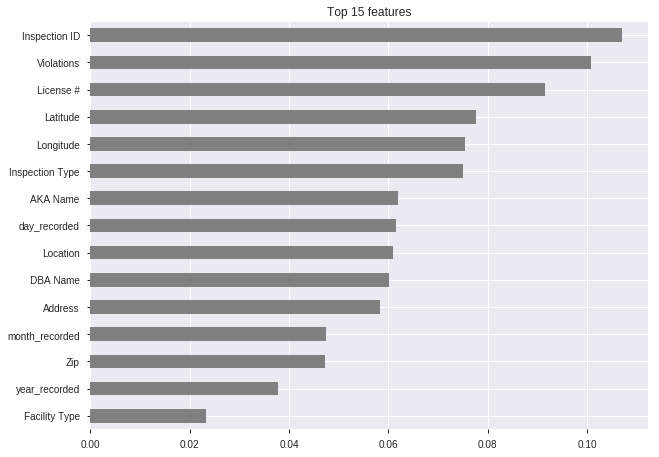

In [231]:
# Get feature importances
rand_f = RF.named_steps['randomforestclassifier']
importances = pd.Series(rand_f.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 15
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [0]:
# transform and set model for eli5
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean')
)

# apply transformation pipeline for X_train and X_val
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)

In [233]:
model = RandomForestClassifier(max_depth=10, max_features=0.3278342663656679, n_estimators=426, random_state=11, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features=0.3278342663656679,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=426, n_jobs=-1, oob_score=False,
                       random_state=11, verbose=0, warm_start=False)

In [234]:
import eli5
from eli5.sklearn import PermutationImportance

# instantiate permuter
permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=2,
    random_state=11
)

# fit permuter
permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

# show weights
eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

Weight,Feature
0.0025 ± 0.0006,Inspection Type
0.0016 ± 0.0002,Inspection ID
0.0016 ± 0.0004,Latitude
0.0014 ± 0.0006,year_recorded
0.0014 ± 0.0004,License #
0.0013 ± 0.0003,Facility Type
0.0007 ± 0.0002,Longitude
0.0006 ± 0.0002,DBA Name
0.0005 ± 0.0000,AKA Name
0.0004 ± 0.0001,Location


In [235]:
# Remove features with zero or less feature importance
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

X_train.shape

(41532, 16)

In [236]:
# apply to validation as well
X_val = X_val[features]
X_val.shape

(10384, 16)

In [237]:
# build new pipeline and use features without 0 weight features
RF_reformed = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(max_depth=10,max_features=0.3278342663656679,
                           n_estimators=426, random_state=11, n_jobs=-1)

)

# score
RF_reformed.fit(X_train, y_train)
print ('Validation Accuracy', RF_reformed.score(X_val, y_val))

Validation Accuracy 0.7437403697996918


In [238]:
# rerun ROC score
y_pred_proba = RF_reformed.predict_proba(X_val)[:, 1]
AUC_ROC = roc_auc_score(y_val, y_pred_proba)
print('ROC AUC Score: ', AUC_ROC)

ROC AUC Score:  0.61748520872502


hmm it is a little worse.

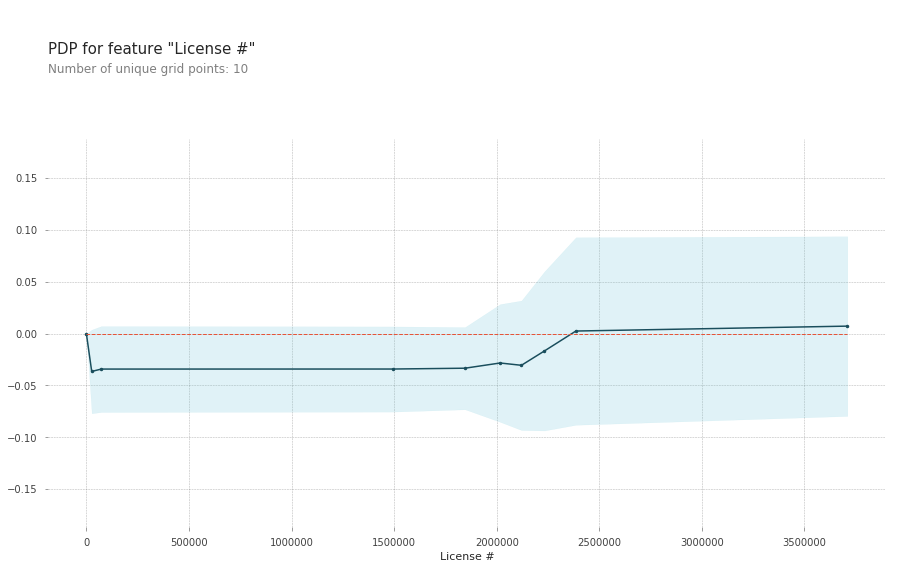

In [243]:
# single feature partial dependency plot
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'License #'

isolated = pdp_isolate(
    model = RF_reformed,
    dataset = X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

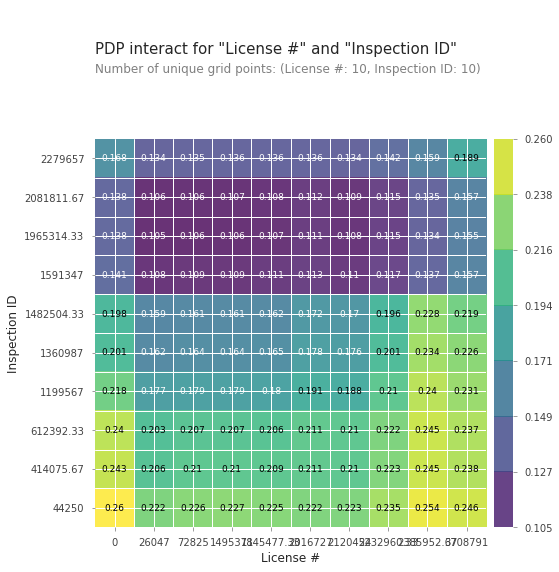

In [244]:
# multifeature partial dependency plots
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['License #', 'Inspection ID']

interaction = pdp_interact(
  model=RF_reformed,
  dataset=X_val,
  model_features=X_val.columns,
  features=features 
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

### Summary

While I was able to reproduce the code and apply it to my model. The interpretation and application is still hazy to me.<br/>
I was expecting to find leakage, but it wasn't there. I am guessing that I missed something along the way. From there I feel like I lost control<br/>
and was simply plugging in my code to fufill the assignment, but not applying the concepts I learned in class.<br/>
I am interested in where I went wrong and what threw me off course.